# Packages

In [61]:
!apt-get update
!pip install requests
!pip install beautifulsoup4
!pip install pandas
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install chromedriver-autoinstaller selenium-stealth
!pip install selenium
!pip install webdriver-manager

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

In [62]:
import time

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium_stealth import stealth
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException, NoSuchElementException

import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get Links to Recipes

In [ ]:
def get_driver():
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    stealth(
        driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
    )
    return driver

In [ ]:
driver = get_driver()

url = "https://www.skinnytaste.com/recipe-index/"
driver.get(url)
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')

recipe_links = []
page = 1

while page <= 50:
    # Important to wait for some time to let the links update for the next page. Otherwise
    # soup will extract the same links of the previous page.
    time.sleep(5)

    # Since we are visiting a new page, we have to create a new bs4 object with current page source.
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    links = soup.select('.entry-header .entry-title a')
    for link in links:
        recipe_links.append(link['href'])
        print(f"Adding {link['href']}")

    try:
        wait = WebDriverWait(driver, 15)
        page_link = wait.until(
            EC.element_to_be_clickable(
                (By.XPATH,
                 '//a[@class="facetwp-page" and @data-page="' + str(page + 1) + '"]')
            )
        )
        page += 1

        # There is a signin overlay in the website. It disables any clicking functionality.
        # So, we have to use JavaScript to click on the next pages.
        driver.execute_script("arguments[0].click();", page_link)
    except TimeoutException:
        # If next page buttons are still not available after waiting for 15 seconds,
        # we will try again from the same page. That's why the page number is not updated.
        continue

driver.quit()

Adding https://www.skinnytaste.com/free-7-day-healthy-meal-plan-sept-30-oct-6/
Adding https://www.skinnytaste.com/freezer-breakfast-burritos/
Adding https://www.skinnytaste.com/crustless-pumpkin-pie/
Adding https://www.skinnytaste.com/red-curry-salmon/
Adding https://www.skinnytaste.com/apple-butter-recipe/
Adding https://www.skinnytaste.com/roasted-delicata-squash/
Adding https://www.skinnytaste.com/applesauce-nut-bread/
Adding https://www.skinnytaste.com/autumn-salad-with-pears-and-gorgonzola/
Adding https://www.skinnytaste.com/sesame-chicken/
Adding https://www.skinnytaste.com/bacon-in-the-oven/
Adding https://www.skinnytaste.com/skinny-pumpkin-spiced-latte/
Adding https://www.skinnytaste.com/homemade-hamburger-helper/
Adding https://www.skinnytaste.com/fried-brown-rice/
Adding https://www.skinnytaste.com/easy-sheet-pan-dinners/
Adding https://www.skinnytaste.com/asian-grilled-chicken-33-pts_3510/
Adding https://www.skinnytaste.com/sweet-potato-salad/
Adding https://www.skinnytaste.

In [ ]:
len(recipe_links)

1000

In [ ]:
with open("urls.txt", "w") as file:
    for link in recipe_links:
        file.write(link + "\n")

# Load Recipe Links

In [ ]:
with open("urls.txt", "r") as file:
    recipe_links = [line.rstrip('\n') for line in file]

# Scrape Recipes

In [ ]:
recipe_info = []
skipped_links = []
last_scraped = 0

In [ ]:
for i, link in enumerate(recipe_links[:370]):

    driver = get_driver()

    driver.get(link)
    time.sleep(5)
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    info = {}
    info['id'] = i

    try:
        name = soup.find('h2', class_='wprm-recipe-name')
        if name:
            try:
                info['name'] = name.text.strip()
            except KeyError as e:
                continue
        else:
            continue

        points = soup.select_one('.wprm-recipe-custom-field.wprm-recipe-custom-field-type-text')
        if points:
            info['points'] = points.get_text(strip=True)
        else:
            continue

        img = soup.select_one('.wprm-recipe-image-container img')
        if img:
            try:
                info['img'] = img['data-lazy-src'] or None
            except KeyError as e:
                continue
        else:
            continue

        calories = soup.find('span', class_='wprm-recipe-details wprm-recipe-nutrition wprm-recipe-calories wprm-block-text-bold')
        if calories:
            info['calories'] = calories.get_text(strip=True)
        else:
            continue

        summary = soup.find('div', class_='wprm-recipe-summary').find('span')
        if summary:
            info['summary'] = summary.get_text(strip=True)
        else:
            continue

        key_tags = soup.select('.post-meta-detail.post-types-snippet .cat-icons.post-icons a')
        if key_tags:
            keys = [anchor.get_text(strip=True) for anchor in key_tags]
            info['keys'] = " ".join(keys)
        else:
            continue

        recipe_info.append(info)
        last_scraped = i

        driver.quit()

    except Exception as e:
        print(f"Skipping {link['href']} - {e}")
        skipped_links.append(i)
        driver.quit()
        continue

In [ ]:
print(last_scraped)

369


In [ ]:
len(recipe_info)

822

# Save Dataset

In [ ]:
dataset = pd.DataFrame(recipe_info)
dataset.to_csv("data.csv", index=False)

In [ ]:
dataset.head(5)

,id,name,points,img,calories,summary,keys
0,0,Pasta Fagioli (Pasta and Beans),4,https://www.skinnytaste.com/wp-content/uploads...,262.5,Italian Pasta Fagioli (Pasta and Beans) is a g...,DF FM GF HF KF PC Q V
1,2,Raw Beet Salad with Apples and Carrots,2,https://www.skinnytaste.com/wp-content/uploads...,112,"Crunchy, bright and sweet, the healthy Raw Bee...",DF GF KF Q V
2,3,Teriyaki Shrimp Quinoa Bowls with Mango-Cucumb...,6,https://www.skinnytaste.com/wp-content/uploads...,352,These fresh and delicious Teriyaki Shrimp Quin...,DF GF HP HF
3,4,Black Beans and Rice,6,https://www.skinnytaste.com/wp-content/uploads...,236,This quick and easy recipe for Black Beans and...,DF FM GF KF V
4,6,Air Fryer Breakfast Banana Split,5,https://www.skinnytaste.com/wp-content/uploads...,286,"If you need a quick and healthy breakfast, you...",AF KF Q


# Load Dataset

In [81]:
dataset = pd.read_csv('/content/drive/MyDrive/mini-project/data.csv')
dataset.head(10)

,id,name,points,img,calories,summary,keys
0,0,Pasta Fagioli (Pasta and Beans),4,https://www.skinnytaste.com/wp-content/uploads...,262.5,Italian Pasta Fagioli (Pasta and Beans) is a g...,DF FM GF HF KF PC Q V
1,2,Raw Beet Salad with Apples and Carrots,2,https://www.skinnytaste.com/wp-content/uploads...,112.0,"Crunchy, bright and sweet, the healthy Raw Bee...",DF GF KF Q V
2,3,Teriyaki Shrimp Quinoa Bowls with Mango-Cucumb...,6,https://www.skinnytaste.com/wp-content/uploads...,352.0,These fresh and delicious Teriyaki Shrimp Quin...,DF GF HP HF
3,4,Black Beans and Rice,6,https://www.skinnytaste.com/wp-content/uploads...,236.0,This quick and easy recipe for Black Beans and...,DF FM GF KF V
4,6,Air Fryer Breakfast Banana Split,5,https://www.skinnytaste.com/wp-content/uploads...,286.0,"If you need a quick and healthy breakfast, you...",AF KF Q
5,7,Red Thai Coconut Curry Shrimp,2,https://www.skinnytaste.com/wp-content/uploads...,136.0,"If you love Thai food, you'll love this easy R...",DF GF LC
6,8,Ground Turkey Skillet with Sweet Potatoes and ...,8,https://www.skinnytaste.com/wp-content/uploads...,394.0,This quick and easy Ground Turkey Skillet with...,DF GF HP HF MP
7,9,Avgolemono Chicken and Rice Soup,6,https://www.skinnytaste.com/wp-content/uploads...,265.0,"You'll love this delicious, silky Greek Avgole...",DF GF HP KF Q
8,10,Pavlova,11,https://www.skinnytaste.com/wp-content/uploads...,221.5,"Pavlova is an elegant, light dessert that pair...",GF
9,11,Broccoli Salad Recipe,5,https://www.skinnytaste.com/wp-content/uploads...,171.0,Delicious Broccoli Salad recipe made with baco...,GF LC MP Q


# Preprocess

Here, I have made the recipe key easily accessible for the further execution, so processed them.

In [82]:
df = pd.concat([dataset.drop(['keys'], axis=1), dataset['keys'].str.get_dummies(sep=' ')], axis=1)

In [83]:
df.head(5)

,id,name,points,img,calories,summary,AF,DF,FM,GF,HF,HP,KF,LC,MP,PC,Q,SC,V,W
0,0,Pasta Fagioli (Pasta and Beans),4,https://www.skinnytaste.com/wp-content/uploads...,262.5,Italian Pasta Fagioli (Pasta and Beans) is a g...,0,1,1,1,1,0,1,0,0,1,1,0,1,0
1,2,Raw Beet Salad with Apples and Carrots,2,https://www.skinnytaste.com/wp-content/uploads...,112.0,"Crunchy, bright and sweet, the healthy Raw Bee...",0,1,0,1,0,0,1,0,0,0,1,0,1,0
2,3,Teriyaki Shrimp Quinoa Bowls with Mango-Cucumb...,6,https://www.skinnytaste.com/wp-content/uploads...,352.0,These fresh and delicious Teriyaki Shrimp Quin...,0,1,0,1,1,1,0,0,0,0,0,0,0,0
3,4,Black Beans and Rice,6,https://www.skinnytaste.com/wp-content/uploads...,236.0,This quick and easy recipe for Black Beans and...,0,1,1,1,0,0,1,0,0,0,0,0,1,0
4,6,Air Fryer Breakfast Banana Split,5,https://www.skinnytaste.com/wp-content/uploads...,286.0,"If you need a quick and healthy breakfast, you...",1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [84]:
df.describe()

,id,points,calories,AF,DF,FM,GF,HF,HP,KF,LC,MP,PC,Q,SC,V,W
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,201.720195,5.058394,239.409732,0.114355,0.484185,0.152068,0.746959,0.266423,0.239659,0.537713,0.279805,0.169100,0.036496,0.476886,0.024331,0.447689,0.124088
std,135.988409,2.840716,118.330713,0.318436,0.500054,0.359306,0.435019,0.442357,0.427135,0.498879,0.449177,0.375068,0.187636,0.499770,0.154168,0.497559,0.329882
min,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,3.000000,147.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,188.500000,5.000000,227.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,308.000000,7.000000,312.600000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,497.000000,13.000000,608.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# EDA

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")

## Calories Distribution

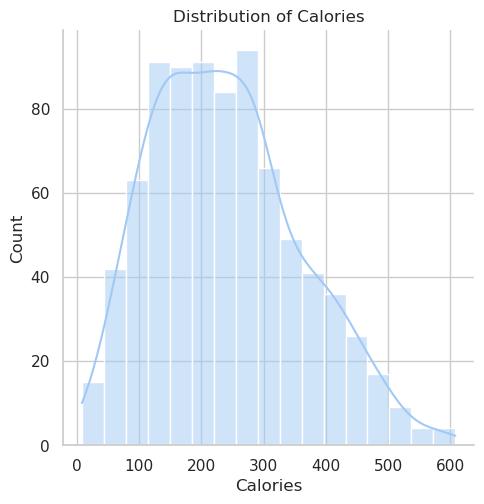

In [ ]:
sns.displot(x=df["calories"], kde=True)
plt.xlabel("Calories")
plt.title("Distribution of Calories")
plt.show()

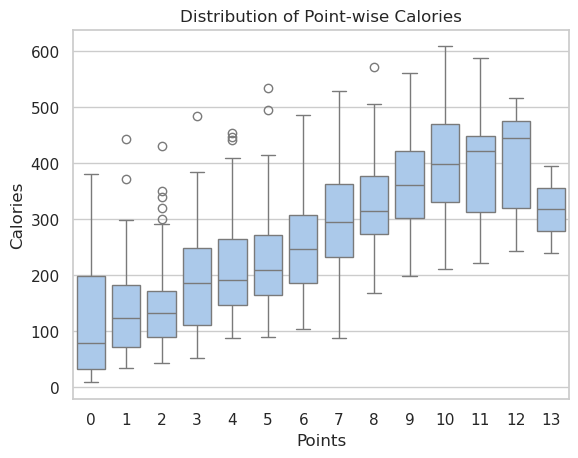

In [ ]:
sns.boxplot(y=df["calories"], x=df["points"])
plt.xlabel("Points")
plt.ylabel("Calories")
plt.title("Distribution of Point-wise Calories")
plt.show()

# Recipe Key Distribution

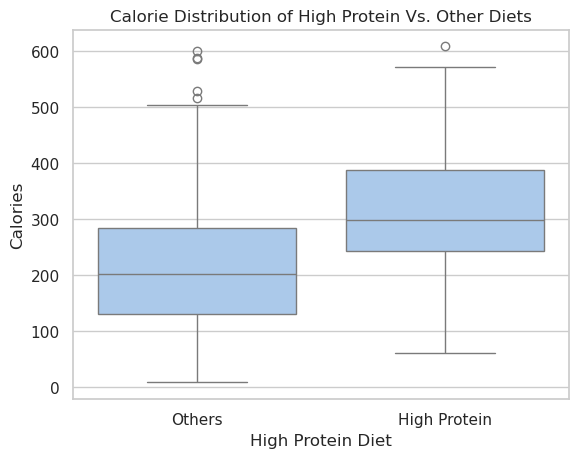

In [ ]:
sns.boxplot(y=df["calories"], x=df["HP"])
plt.xlabel("High Protein Diet")
plt.xticks([0, 1], ['Others', 'High Protein'])
plt.ylabel("Calories")
plt.title("Calorie Distribution of High Protein Vs. Other Diets")
plt.show()

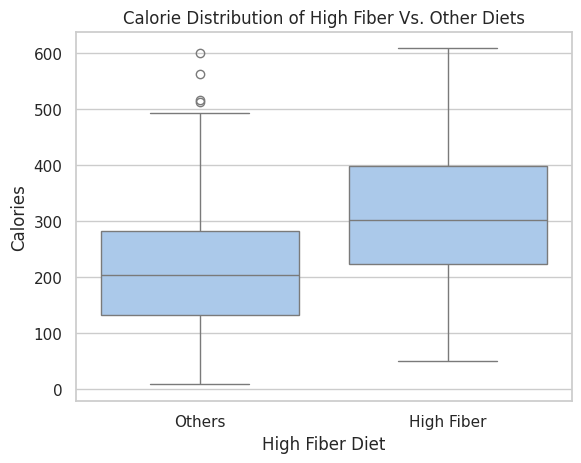

In [63]:
sns.boxplot(y=df["calories"], x=df["HF"])
plt.xlabel("High Fiber Diet")
plt.xticks([0, 1], ['Others', 'High Fiber'])
plt.ylabel("Calories")
plt.title("Calorie Distribution of High Fiber Vs. Other Diets")
plt.show()

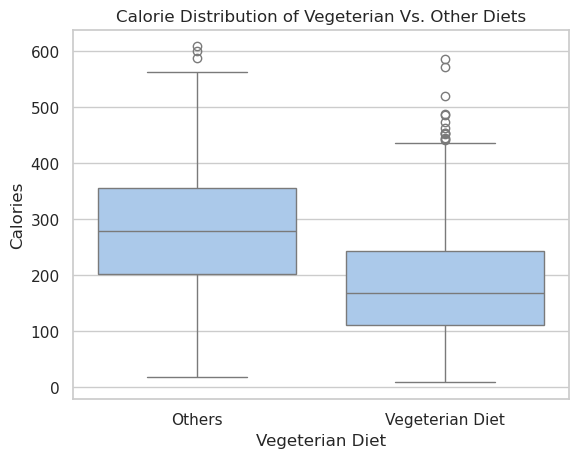

In [ ]:
sns.boxplot(y=df["calories"], x=df["V"])
plt.xlabel("Vegeterian Diet")
plt.xticks([0, 1], ['Others', 'Vegeterian Diet'])
plt.ylabel("Calories")
plt.title("Calorie Distribution of Vegeterian Vs. Other Diets")
plt.show()

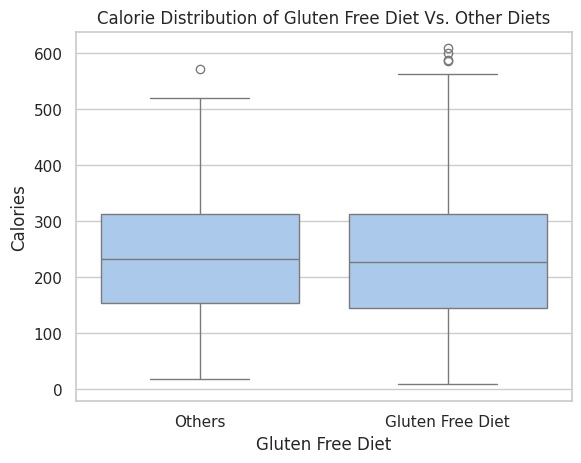

In [64]:
sns.boxplot(y=df["calories"], x=df["GF"])
plt.xlabel("Gluten Free Diet")
plt.xticks([0, 1], ['Others', 'Gluten Free Diet'])
plt.ylabel("Calories")
plt.title("Calorie Distribution of Gluten Free Diet Vs. Other Diets")
plt.show()

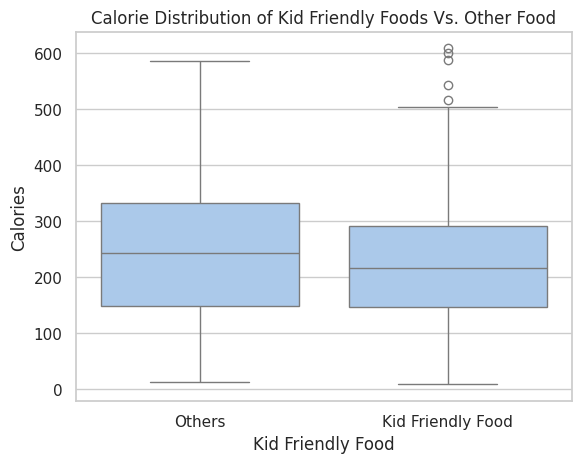

In [65]:
sns.boxplot(y=df["calories"], x=df["KF"])
plt.xlabel("Kid Friendly Food")
plt.xticks([0, 1], ['Others', 'Kid Friendly Food'])
plt.ylabel("Calories")
plt.title("Calorie Distribution of Kid Friendly Foods Vs. Other Food")
plt.show()

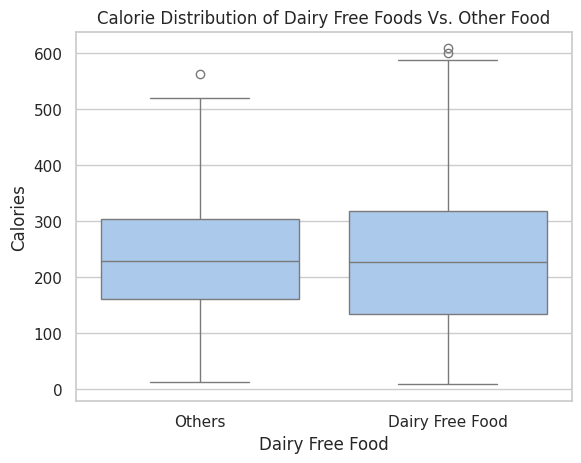

In [67]:
sns.boxplot(y=df["calories"], x=df["DF"])
plt.xlabel("Dairy Free Food")
plt.xticks([0, 1], ['Others', 'Dairy Free Food'])
plt.ylabel("Calories")
plt.title("Calorie Distribution of Dairy Free Foods Vs. Other Food")
plt.show()

# Point Distribution

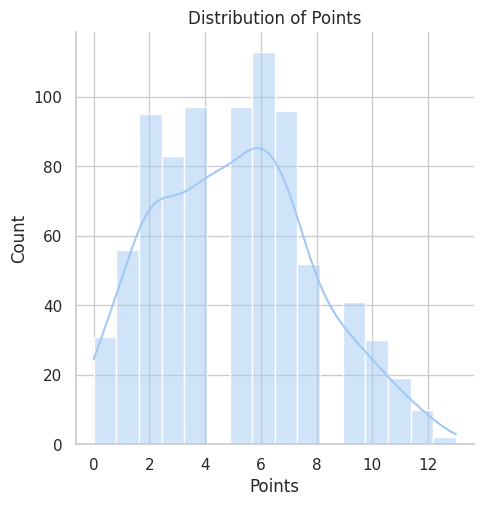

In [66]:
sns.displot(x=df["points"], kde=True)
plt.xlabel("Points")
plt.title("Distribution of Points")
plt.show()

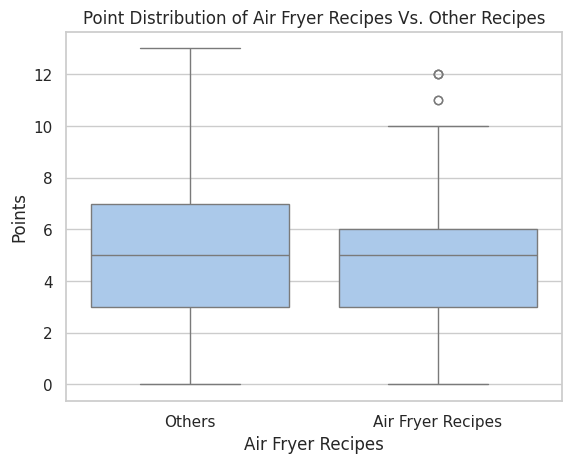

In [69]:
sns.boxplot(y=df["points"], x=df["AF"])
plt.xlabel("Air Fryer Recipes")
plt.xticks([0, 1], ['Others', 'Air Fryer Recipes'])
plt.ylabel("Points")
plt.title("Point Distribution of Air Fryer Recipes Vs. Other Recipes")
plt.show()

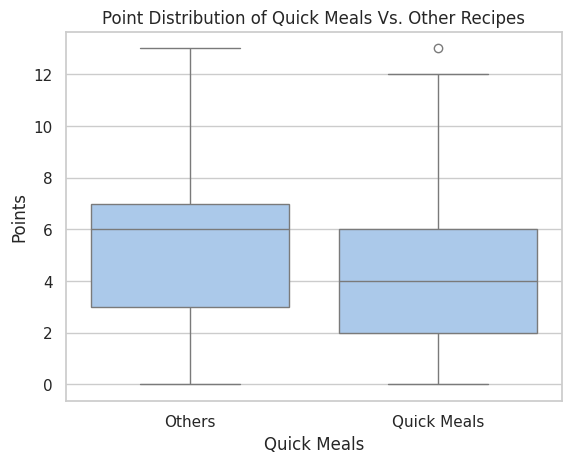

In [72]:
sns.boxplot(y=df["points"], x=df["Q"])
plt.xlabel("Quick Meals")
plt.xticks([0, 1], ['Others', 'Quick Meals'])
plt.ylabel("Points")
plt.title("Point Distribution of Quick Meals Vs. Other Recipes")
plt.show()

# User Interaction-1

Here, I tried to create an user interface, where user can filter their preferred values. But there is a problem in this section is: All the image url can not be executed. But some of them are visible after filtering.

In [85]:
from IPython.display import display, Image
import ipywidgets as widgets

In [86]:
calorie_min = widgets.IntText(description='Min Calories:')
calorie_max = widgets.IntText(description='Max Calories:')
point_min = widgets.IntText(description='Min Points:')
point_max = widgets.IntText(description='Max Points:')

In [87]:
filter_button = widgets.Button(description='Filter')
output = widgets.Output()

In [96]:
def filter_and_display(button):
    min_calories = calorie_min.value
    max_calories = calorie_max.value
    min_points = point_min.value
    max_points = point_max.value

    filtered_df = df[(df['calories'] >= min_calories) & (df['calories'] <= max_calories) &
                     (df['points'] >= min_points) & (df['points'] <= max_points)].head(10)

    output.clear_output()

    for index, row in filtered_df.iterrows():
        display(widgets.HTML(f"<h4>{row['name']}</h4>"))
        # Check if 'image_url' column exists before accessing it
        if 'img' in filtered_df.columns:
            display(Image(url=row['img']))
        #else:
            # Handle the case where 'image_url' is missing, e.g., print a message
            print("Image URL not available for this recipe.")
        display(widgets.HTML(f"<p>{row['summary']}</p>"))

In [97]:
filter_button.on_click(filter_and_display)

In [98]:
display(widgets.HBox([calorie_min, calorie_max, point_min, point_max, filter_button]))
display(output)

Output()

HTML(value='<h4>Pasta Fagioli (Pasta and Beans)</h4>')

Image URL not available for this recipe.


HTML(value='<p>Italian Pasta Fagioli (Pasta and Beans) is a great tasting, hearty, vegetarian pasta and bean s…

HTML(value='<h4>Raw Beet Salad with Apples and Carrots</h4>')

Image URL not available for this recipe.


HTML(value='<p>Crunchy, bright and sweet, the healthy Raw Beet Salad with Apples and Carrots is a delicious wa…

HTML(value='<h4>Teriyaki Shrimp Quinoa Bowls with Mango-Cucumber Salsa</h4>')

Image URL not available for this recipe.


HTML(value='<p>These fresh and delicious Teriyaki Shrimp Quinoa Bowls seasoned with honey, ginger, and soy sau…

HTML(value='<h4>Black Beans and Rice</h4>')

Image URL not available for this recipe.


HTML(value='<p>This quick and easy recipe for Black Beans and Rice is delicious! Made with sofrito, canned bla…

HTML(value='<h4>Air Fryer Breakfast Banana Split</h4>')

Image URL not available for this recipe.


HTML(value='<p>If you need a quick and healthy breakfast, you’ll love this six-minute Air Fryer Breakfast Bana…

HTML(value='<h4>Red Thai Coconut Curry Shrimp</h4>')

Image URL not available for this recipe.


HTML(value="<p>If you love Thai food, you'll love this easy Red Thai Coconut Curry Shrimp, the perfect balance…

HTML(value='<h4>Ground Turkey Skillet with Sweet Potatoes and Black Bean</h4>')

Image URL not available for this recipe.


HTML(value='<p>This quick and easy Ground Turkey Skillet with sweet potatoes, black beans, corn, and tomatoes …

HTML(value='<h4>Avgolemono Chicken and Rice Soup</h4>')

Image URL not available for this recipe.


HTML(value="<p>You'll love this delicious, silky Greek Avgolemono soup filled with chicken, rice and dill with…

HTML(value='<h4>Broccoli Salad Recipe</h4>')

Image URL not available for this recipe.


HTML(value='<p>Delicious Broccoli Salad recipe made with bacon, sunflower seeds, red onion, and goat cheese mi…

HTML(value='<h4>Braised Kale with Pancetta</h4>')

Image URL not available for this recipe.


HTML(value='<p>Braised Kale with Pancetta, garlic, and onion, a healthy side dish to pair with any protein, is…

HTML(value='<h4>Pasta Fagioli (Pasta and Beans)</h4>')

Image URL not available for this recipe.


HTML(value='<p>Italian Pasta Fagioli (Pasta and Beans) is a great tasting, hearty, vegetarian pasta and bean s…

HTML(value='<h4>Raw Beet Salad with Apples and Carrots</h4>')

Image URL not available for this recipe.


HTML(value='<p>Crunchy, bright and sweet, the healthy Raw Beet Salad with Apples and Carrots is a delicious wa…

HTML(value='<h4>Teriyaki Shrimp Quinoa Bowls with Mango-Cucumber Salsa</h4>')

Image URL not available for this recipe.


HTML(value='<p>These fresh and delicious Teriyaki Shrimp Quinoa Bowls seasoned with honey, ginger, and soy sau…

HTML(value='<h4>Black Beans and Rice</h4>')

Image URL not available for this recipe.


HTML(value='<p>This quick and easy recipe for Black Beans and Rice is delicious! Made with sofrito, canned bla…

HTML(value='<h4>Air Fryer Breakfast Banana Split</h4>')

Image URL not available for this recipe.


HTML(value='<p>If you need a quick and healthy breakfast, you’ll love this six-minute Air Fryer Breakfast Bana…

HTML(value='<h4>Red Thai Coconut Curry Shrimp</h4>')

Image URL not available for this recipe.


HTML(value="<p>If you love Thai food, you'll love this easy Red Thai Coconut Curry Shrimp, the perfect balance…

HTML(value='<h4>Ground Turkey Skillet with Sweet Potatoes and Black Bean</h4>')

Image URL not available for this recipe.


HTML(value='<p>This quick and easy Ground Turkey Skillet with sweet potatoes, black beans, corn, and tomatoes …

HTML(value='<h4>Avgolemono Chicken and Rice Soup</h4>')

Image URL not available for this recipe.


HTML(value="<p>You'll love this delicious, silky Greek Avgolemono soup filled with chicken, rice and dill with…

HTML(value='<h4>Broccoli Salad Recipe</h4>')

Image URL not available for this recipe.


HTML(value='<p>Delicious Broccoli Salad recipe made with bacon, sunflower seeds, red onion, and goat cheese mi…

HTML(value='<h4>Braised Kale with Pancetta</h4>')

Image URL not available for this recipe.


HTML(value='<p>Braised Kale with Pancetta, garlic, and onion, a healthy side dish to pair with any protein, is…

HTML(value='<h4>Pasta Fagioli (Pasta and Beans)</h4>')

HTML(value='<p>Italian Pasta Fagioli (Pasta and Beans) is a great tasting, hearty, vegetarian pasta and bean s…

HTML(value='<h4>Raw Beet Salad with Apples and Carrots</h4>')

HTML(value='<p>Crunchy, bright and sweet, the healthy Raw Beet Salad with Apples and Carrots is a delicious wa…

HTML(value='<h4>Teriyaki Shrimp Quinoa Bowls with Mango-Cucumber Salsa</h4>')

HTML(value='<p>These fresh and delicious Teriyaki Shrimp Quinoa Bowls seasoned with honey, ginger, and soy sau…

HTML(value='<h4>Black Beans and Rice</h4>')

HTML(value='<p>This quick and easy recipe for Black Beans and Rice is delicious! Made with sofrito, canned bla…

HTML(value='<h4>Air Fryer Breakfast Banana Split</h4>')

HTML(value='<p>If you need a quick and healthy breakfast, you’ll love this six-minute Air Fryer Breakfast Bana…

HTML(value='<h4>Red Thai Coconut Curry Shrimp</h4>')

HTML(value="<p>If you love Thai food, you'll love this easy Red Thai Coconut Curry Shrimp, the perfect balance…

HTML(value='<h4>Ground Turkey Skillet with Sweet Potatoes and Black Bean</h4>')

HTML(value='<p>This quick and easy Ground Turkey Skillet with sweet potatoes, black beans, corn, and tomatoes …

HTML(value='<h4>Avgolemono Chicken and Rice Soup</h4>')

HTML(value="<p>You'll love this delicious, silky Greek Avgolemono soup filled with chicken, rice and dill with…

HTML(value='<h4>Broccoli Salad Recipe</h4>')

HTML(value='<p>Delicious Broccoli Salad recipe made with bacon, sunflower seeds, red onion, and goat cheese mi…

HTML(value='<h4>Braised Kale with Pancetta</h4>')

HTML(value='<p>Braised Kale with Pancetta, garlic, and onion, a healthy side dish to pair with any protein, is…

# User Interaction-2

Here users have to give values and makes choices if they want to see the recipe by point or calories, both can be possible.

In [99]:
def get_user_preferences():
    print("Please enter your preferences (or type 'exit' to quit):")
    min_point = input("Enter minimum point: ")
    if min_point.lower() == 'exit':
        return None

    max_point = input("Enter maximum point: ")
    if max_point.lower() == 'exit':
        return None

    min_calories= input("Enter minimum calories: ")
    if min_calories.lower() == 'exit':
        return None

    max_calories = input("Enter maximum calories: ")
    if max_calories.lower() == 'exit':
        return None


    return float(min_point), float(max_point), float(min_calories), int(max_calories)

def filter_recipe(min_point, max_point, min_calories, max_calories):
    filtered_recipes = df[
        (df['points'] >= min_point) &
        (df['points'] <= max_point) &
        (df['calories'] >= min_calories) &
        (df['calories'] <= max_calories)
    ]

    return filtered_recipes

def get_sort_criteria():
    print("\nSort Recipe by:")
    print("1. Points")
    print("2. Calories")
    sort_option = int(input("Enter the number corresponding to your choice: "))

    if sort_option == 1:
        sort_by = 'Points'
    elif sort_option == 2:
        sort_by = 'Calories'
    else:
        print("Invalid choice. Defaulting to sorting by Point.")
        sort_by = 'Points'

    return sort_by

def display_filtered_recipe(filtered_recipes):
    if filtered_recipes.empty:
        print("No recipes match your preferences.")
    print("\nHere are the recipes based on your preferences:")
    print(filtered_recipes[['name','points','calories','summary','img']])


def get_recipe_details(name):
    name = df[df['name'] == name]

    if name.empty:
        print("Recipe not found!")
        return

    print("\nRecipe:")
    print(f"Name: {df.iloc[0]['name']}")
    print(f"Points: {df.iloc[0]['points']}")
    print(f"Calories: ${df.iloc[0]['calories']}")
    print(f"Summary: {df.iloc[0]['summary']}")
    print(f"Key: {df.iloc[0]['keys']}")


def main():
    min_point, max_point, min_calories, max_calories = get_user_preferences() # Changed this line to correctly unpack the values returned by the function.
    filtered_recipes = filter_recipe(min_point, max_point, min_calories, max_calories)

    if filtered_recipes.empty:
        print("No recipes match your preferences.")
        return

    sort_by = get_sort_criteria()
    # Changed 'Points' to 'points' to match the DataFrame column name
    if sort_by == 'Points':
        sort_by = 'points'
    else:
        sort_by = 'calories'
    sorted_recipe = filtered_recipes.sort_values(by=sort_by, ascending=True)

    display_filtered_recipe(sorted_recipe.head(10))

In [100]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
main()

Please enter your preferences (or type 'exit' to quit):
Enter minimum point: 2
Enter maximum point: 8
Enter minimum calories: 100
Enter maximum calories: 400

Sort Recipe by:
1. Points
2. Calories
Enter the number corresponding to your choice: 2

Here are the recipes based on your preferences:
                               name  points  calories                                            summary                                                img
480                   Caprese Salad       4     100.0  Caprese salad is a simple summer salad with fr...  https://www.skinnytaste.com/wp-content/uploads...
37      Asian Chicken Lettuce Wraps       3     102.0  These quick and easy authentic Asian Chicken L...  https://www.skinnytaste.com/wp-content/uploads...
735        Grilled Pineapple Recipe       4     102.0  This quick and easy Grilled Pineapple recipe w...  https://www.skinnytaste.com/wp-content/uploads...
351        Skillet Mexican Zucchini       4     102.0  Skillet Mexican Zucchini i